In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import sys, distutils.core
sys.path.insert(0, os.path.abspath('../detectron2'))
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../projects/Panoptic-DeepLab/'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'

from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import add_panoptic_deeplab_config

from prediction import Predictor
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

torch.set_num_threads(2)

/home/liwa/miniconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8700m"
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")

cfg.MODEL.DEVICE = "cuda"
# into cpu model
# cfg.MODEL.SEM_SEG_HEAD.NORM = "BN"
# cfg.MODEL.INS_EMBED_HEAD.NORM = "BN"
# cfg.MODEL.RESNETS.NORM = "BN"

cfg.MODEL.PANOPTIC_DEEPLAB.TOP_K_INSTANCE = None
cfg.MODEL.PANOPTIC_DEEPLAB.INSTANCE_AREA_THRESHOLD = 3000

# cfg.MODEL.PANOPTIC_DEEPLAB.CENTER_THRESHOLD = 0.1
# cfg.MODEL.PANOPTIC_DEEPLAB.PREDICT_INSTANCES = False
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/oneformer_output/output/model_0059999.pth")

# torch.save(model.state_dict(), "model.pth")
# torch.save(predictor.model.state_dict(), "/home/liwa/data/Oneformer_model/test_save_model.pth")

In [3]:
predictor = Predictor(cfg)

### Test

In [4]:
from pathlib import Path
from skimage.io import imread, imsave
import numpy as np

import matplotlib.pyplot as plt
from post_process_utils import get_largest_object, convert_to_rgb, segment_slide_window, segment_post_process
%load_ext autoreload
%autoreload 2

In [5]:
movie_path_list = list(Path("/home/liwa/data/mating_data/patch/").rglob("*_rigid.tif"))
movie_path_list = [str(x) for x in movie_path_list]
movie_path_list.sort()
movie_path_list

['/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_2_R3D_merge_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_3_R3D_merge_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_5_R3D_merge_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_6_R3D_merge_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/1_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/2_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/3_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/4_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/5_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/6_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/1_rigid.tif',
 '/home/liwa/data/mating_data/patch/20240607_2scd

In [12]:
im = imread(movie_path_list[0])[-1, 1024:2048, 1024:2048, 0]#[23, 0, 0:1300, 0:1300]
# im = convert_to_rgb(im)

In [13]:
im = convert_to_rgb(im)
im.shape

(1016, 1016, 3)

In [19]:
with torch.no_grad():
    prediction_output = predictor(im)
    panoptic_seg, _ = prediction_output["panoptic_seg"]
    panoptic_seg = panoptic_seg.to("cpu")
    panopitc_labels = np.unique(panoptic_seg)
    panopitc_labels = panopitc_labels[panopitc_labels>1000]
    
    instances = prediction_output["instances"]
    scores = list(instances.center_scores.to("cpu"))
    bboxes = instances.pred_boxes.to("cpu")
    
    segments_info = []
    
    if len(panopitc_labels) == len(scores):
        for idx, panoptic_label in enumerate(panopitc_labels):
            a ,b, c, d = bboxes[idx].tensor[0]
            if (a == 0) | (b == 0) | (c == 1300) | (d == 1300) | (scores[idx] < 0.3):
                panoptic_seg[panoptic_seg==panoptic_label] = -1
                continue
            
            segments_info.append(
                {
                    "id": int(panoptic_label),
                    "category_id": int(panoptic_label // 1000),
                    "isthing": True,
                    "score": float(scores[idx]),
                }
            )

{1006: {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.9757595062255859}, 1007: {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 0.9947394132614136}, 1009: {'id': 1009, 'category_id': 1, 'isthing': True, 'score': 0.9974298477172852}, 1010: {'id': 1010, 'category_id': 1, 'isthing': True, 'score': 0.990865170955658}, 1011: {'id': 1011, 'category_id': 1, 'isthing': True, 'score': 1.0090906620025635}, 1012: {'id': 1012, 'category_id': 1, 'isthing': True, 'score': 1.0172492265701294}, 1013: {'id': 1013, 'category_id': 1, 'isthing': True, 'score': 0.9942960739135742}, 1014: {'id': 1014, 'category_id': 1, 'isthing': True, 'score': 0.9784486293792725}, 1015: {'id': 1015, 'category_id': 1, 'isthing': True, 'score': 0.9905955195426941}, 1016: {'id': 1016, 'category_id': 1, 'isthing': True, 'score': 0.9923932552337646}, 1017: {'id': 1017, 'category_id': 1, 'isthing': True, 'score': 0.9883235692977905}, 1018: {'id': 1018, 'category_id': 1, 'isthing': True, 'score': 0.97782027721

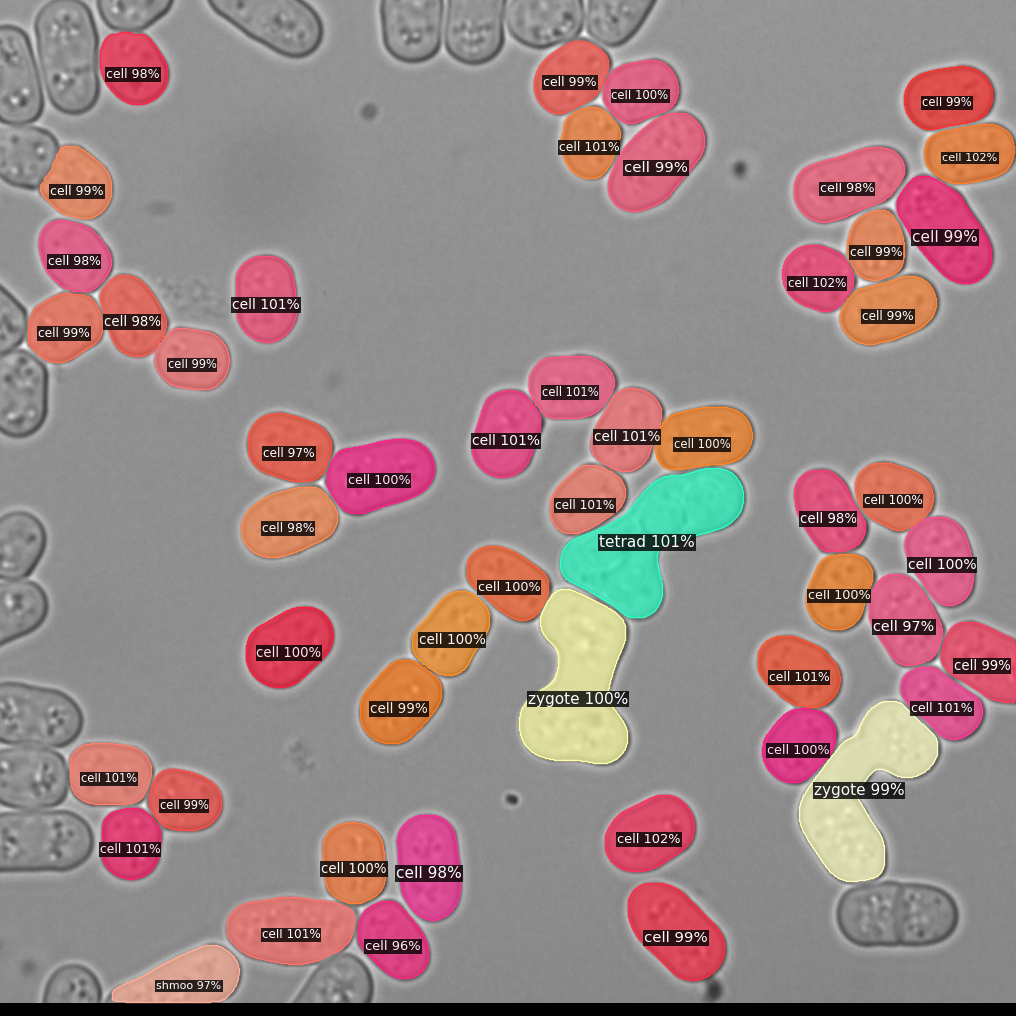

In [20]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
post_precessed_mask = segment_post_process(prediction_output)

In [22]:
import matplotlib.pyplot as plt

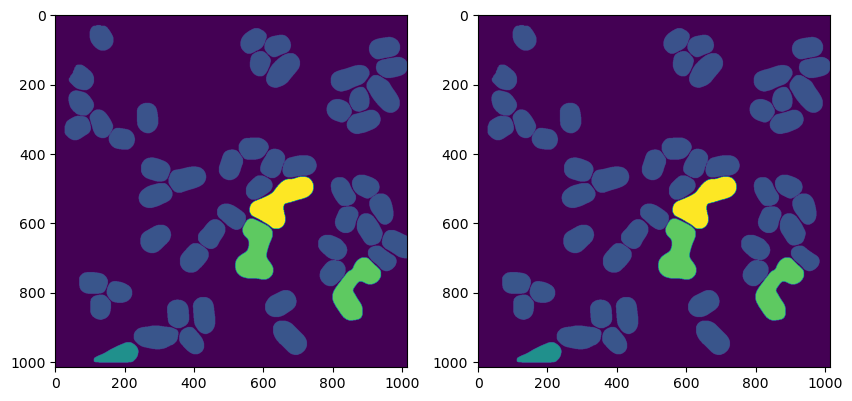

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(panoptic_seg)
axs[1].imshow(post_precessed_mask)

In [24]:
from tqdm import trange

In [22]:
DIVISION = 1000
min_box = 0
max_box = 1200
crops = [[0, max_box ,0,max_box], [0, max_box ,2048-max_box,2048], [2048-max_box,2048,0,max_box], [2048-max_box,2048,2048-max_box,2048]]

for movie_path in movie_path_list:
    print(movie_path)
    movie = imread(movie_path)[:,0, :,:]
    segment_movie = np.zeros(movie.shape, dtype=np.uint16)
    for frame in trange(0, movie.shape[0]):
        try:
            segment_movie[frame] = segment_slide_window(predictor, movie[frame], crops, score_threshold=0.3, ins_threshold=0.6, area_threshold=1000)

        except Exception as e:
            print("Error occurred:", e)
            continue

    imsave(movie_path[:-4]+f"_mask.tif", segment_movie)
    del movie, segment_movie

/home/liwa/data/mating_data/20250624_ywl065/1_rigid/01_ywl065-06_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [57:57<00:00, 19.21s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/02_ywl065-07_rigid.tif


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [1:15:43<00:00, 25.10s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/03_ywl065-10_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [54:34<00:00, 18.09s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/04_ywl065-08_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [48:50<00:00, 16.19s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/05_ywl065-09_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [54:02<00:00, 17.91s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/06_ywl065-03_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [41:49<00:00, 13.87s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/07_ywl065-02_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [38:45<00:00, 12.85s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/08_ywl065-01_rigid.tif


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [1:00:00<00:00, 19.89s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/09_ywl065-04_rigid.tif


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [56:31<00:00, 18.74s/it]


/home/liwa/data/mating_data/20250624_ywl065/1_rigid/10_ywl065-05_rigid.tif


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [1:07:13<00:00, 22.28s/it]


In [42]:
DIVISION = 1000
min_box = 0
max_box = 1200
crops = [[0, max_box ,0,max_box], [0, max_box ,2048-max_box,2048], [2048-max_box,2048,0,max_box], [2048-max_box,2048,2048-max_box,2048]]

for movie_path in movie_path_list:
    print(movie_path)
    orginal_image = imread(movie_path)[:, :,:, 0]
    for idx, (c1, c2, c3, c4) in enumerate(crops):
        try:
            movie = orginal_image[:, c1:c2, c3:c4]
            segment_movie = np.zeros(movie.shape, dtype=np.uint16)
            for frame in trange(0, movie.shape[0]):
                image = movie[frame]
                image = convert_to_rgb(image)
                prediction_output = predictor(image)
                post_precessed_mask = segment_post_process(prediction_output, seg_threshold=0.3, area_threshold=3000)
                segment_movie[frame] = post_precessed_mask
            imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
            del movie, segment_movie
        except Exception as e:
            print("Error occurred:", e)
            continue
    del orginal_image

/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_2_R3D_merge_rigid.tif


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [1:09:55<00:00,  4.76s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_2_R3D_merge_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [50:02<00:00,  3.41s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_2_R3D_merge_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [1:02:44<00:00,  4.27s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mat

/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_3_R3D_merge_rigid.tif


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [1:00:01<00:00,  4.09s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_3_R3D_merge_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [49:03<00:00,  3.34s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_3_R3D_merge_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [51:48<00:00,  3.53s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mat

/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_5_R3D_merge_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [54:37<00:00,  3.72s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_5_R3D_merge_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [43:28<00:00,  2.96s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_5_R3D_merge_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [53:22<00:00,  3.63s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mat

/home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_6_R3D_merge_rigid.tif


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [1:11:09<00:00,  4.85s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_6_R3D_merge_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [40:30<00:00,  2.76s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240427_hm_scd2_hp_scd2/20240427_yml21_44_amp_04_6_R3D_merge_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 881/881 [59:02<00:00,  4.02s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mat

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/1_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [42:58<00:00,  3.25s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/1_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [35:55<00:00,  2.72s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/1_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [45:07<00:00,  3.41s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/1_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/2_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [54:54<00:00,  4.15s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/2_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [48:43<00:00,  3.68s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/2_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [51:20<00:00,  3.88s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/2_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/3_rigid.tif


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [1:12:18<00:00,  5.46s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/3_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [57:41<00:00,  4.36s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/3_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [1:07:24<00:00,  5.09s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/3_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/4_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [51:07<00:00,  3.86s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/4_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [46:24<00:00,  3.51s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/4_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [54:46<00:00,  4.14s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/4_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/5_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [39:22<00:00,  2.98s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/5_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [36:58<00:00,  2.79s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/5_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [47:58<00:00,  3.63s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/5_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/6_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [45:48<00:00,  3.46s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/6_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [35:53<00:00,  2.71s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/6_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [38:42<00:00,  2.92s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_001/6_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/1_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [45:52<00:00,  3.47s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/1_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [36:42<00:00,  2.77s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/1_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [45:17<00:00,  3.42s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/1_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/2_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [54:56<00:00,  4.15s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/2_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [48:39<00:00,  3.68s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/2_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [51:45<00:00,  3.91s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/2_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/3_rigid.tif


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [1:13:09<00:00,  5.53s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/3_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [57:46<00:00,  4.37s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/3_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [1:07:38<00:00,  5.11s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/3_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/4_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [51:50<00:00,  3.92s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/4_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [46:32<00:00,  3.52s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/4_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [55:08<00:00,  4.17s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/4_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/5_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [40:26<00:00,  3.06s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/5_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [37:42<00:00,  2.85s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/5_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [46:08<00:00,  3.49s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/5_rigid_crop_2_mask.tif is a low con

/home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/6_rigid.tif


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [43:50<00:00,  3.31s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/6_rigid_crop_0_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [35:31<00:00,  2.68s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/6_rigid_crop_1_mask.tif is a low contrast image
  imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [36:34<00:00,  2.76s/it]
/tmp/ipykernel_1421483/394214439.py:19: UserWarning: /home/liwa/data/mating_data/patch/20240607_2scd2_gfp_002/6_rigid_crop_2_mask.tif is a low con